In [1]:
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt 
import numpy as np 
import random
import seaborn as sns
import warnings
import time

import tensorflow as tf
from tensorflow.keras.layers import *
# Oversampling
from imblearn.over_sampling import RandomOverSampler

warnings.filterwarnings("ignore")

In [2]:
seed = 101
tf.random.set_seed(seed)

In [3]:
df = pd.read_csv(r'dataset_fix2.csv', header=0)
df = df.drop(['no', 'bloodPressure'], axis=1)


In [4]:
df

,age,gender,respirartoryRate,HeartRate,temperature,hypertension,dm,heartDisease,smoking,STROKE
0,76,P,20,88,36.0,1,1,1,0,1
1,68,p,23,70,36.0,1,1,1,0,1
2,62,p,20,83,36.8,1,1,0,0,1
3,54,L,22,88,37.0,1,0,0,0,1
4,83,L,18,82,36.8,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...
1550,63,P,20,95,35.5,1,0,0,0,0
1551,60,L,20,75,36.7,0,0,1,0,0
1552,50,L,18,80,36.8,0,0,1,0,0
1553,53,L,22,70,37.2,1,0,0,0,0


In [5]:
df.describe()

,age,respirartoryRate,HeartRate,temperature,hypertension,dm,heartDisease,smoking,STROKE
count,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000
mean,52.829582,20.181994,77.218650,36.510611,0.362058,0.022508,0.158199,0.278457,0.099035
std,9.369569,1.748965,12.981317,0.903936,0.480750,0.148376,0.365045,0.448384,0.298806
min,32.000000,18.000000,50.000000,35.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,46.000000,19.000000,69.000000,35.700000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,52.000000,20.000000,75.000000,36.500000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,60.000000,21.000000,85.000000,37.300000,1.000000,0.000000,0.000000,1.000000,0.000000
max,92.000000,40.000000,155.000000,39.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Text(0.5, 1.0, 'Class Frequency\n0 : no stroke\n1: stroke')

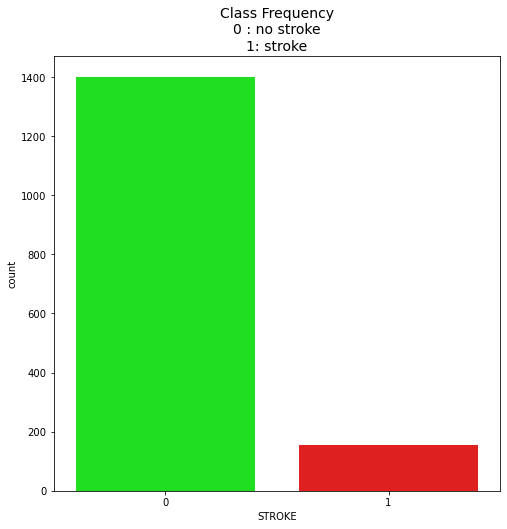

In [6]:
colors = ["#00FF00", "#FF0000"]
fig, ax = plt.subplots(figsize=(8,8))
sns.countplot('STROKE', data=df, ax=ax, palette=colors)
plt.title('Class Frequency\n0 : no stroke\n1: stroke', fontsize=14)

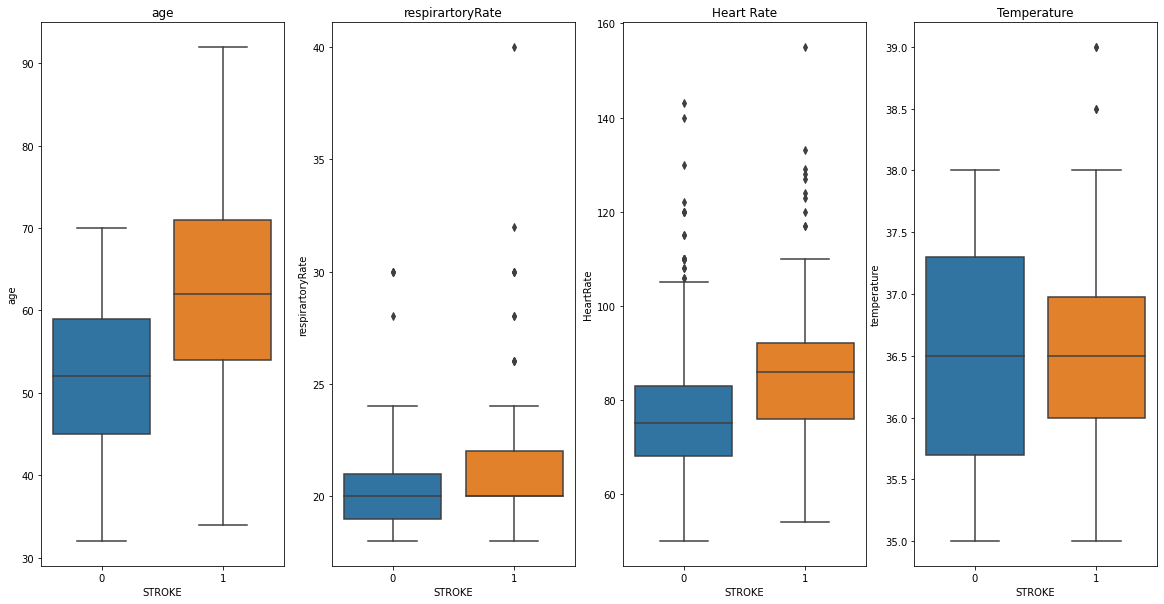

In [7]:
f, axes= plt.subplots(1, 4, figsize = (20, 10))
sns.boxplot(x="STROKE", y="age", data =df, ax=axes[0]).set_title('age')
sns.boxplot(x="STROKE", y="respirartoryRate", data =df, ax=axes[1]).set_title('respirartoryRate')
sns.boxplot(x="STROKE", y="HeartRate", data=df, ax=axes[2]).set_title('Heart Rate')
sns.boxplot(x="STROKE", y="temperature", data=df, ax=axes[3]).set_title('Temperature')
plt.show()

# Convert categorical values to numeric

In [8]:
gender = {'L': 0, 'l' : 0, 'P': 1, 'p' : 1}
df['gender'] = df['gender'].map(gender)

In [9]:
df.head()

,age,gender,respirartoryRate,HeartRate,temperature,hypertension,dm,heartDisease,smoking,STROKE
0,76,1,20,88,36.0,1,1,1,0,1
1,68,1,23,70,36.0,1,1,1,0,1
2,62,1,20,83,36.8,1,1,0,0,1
3,54,0,22,88,37.0,1,0,0,0,1
4,83,0,18,82,36.8,1,0,0,1,1


In [10]:
X = df
y = X.pop('STROKE')

# Intialize Model

In [11]:
def baseline_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(len(X.columns),)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])
    return model

In [12]:
model = baseline_model()

In [13]:
model.fit(X,y, epochs=15)

Train on 1555 samples
1555/1555 [==============================] - 3s 2ms/sample - loss: 0.9268 - accuracy: 0.8521


In [14]:
#m = tf.keras.metrics.Recall()
#m.update_state(np.array(y_res), model.predict_classes(X_res).flatten())
#m.result().numpy()


# Oversample dataset

In [15]:
X_res , y_res = RandomOverSampler(random_state=seed).fit_resample(X, y)

In [16]:
# Fit Model
EPOCHS = 30
BATCH_SIZE = 64

In [17]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

train_acc = []
test_acc = []
history = []
for train_index, test_index in skf.split(X_res, y_res):
    X_train, X_test = X_res.iloc[train_index], X_res.iloc[test_index]
    y_train, y_test = y_res[train_index], y_res[test_index]
    model = baseline_model()
    history += [model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE).history['accuracy']]
    
    m = tf.keras.metrics.Accuracy()
    m.update_state(model.predict_classes(X_train), y_train)
    trainScore = m.result().numpy()

    m = tf.keras.metrics.Accuracy()
    m.update_state(model.predict_classes(X_test), y_test)
    testScore = m.result().numpy()

    
    train_acc.append(trainScore)
    test_acc.append(testScore)

Train on 2241 samples
Epoch 1/30
2241/2241 [==============================] - 2s 692us/sample - loss: 2.0842 - accuracy: 0.5292
Epoch 2/30
2241/2241 [==============================] - 0s 91us/sample - loss: 0.5938 - accuracy: 0.6738
Epoch 3/30
2241/2241 [==============================] - 0s 144us/sample - loss: 0.6039 - accuracy: 0.6658
Epoch 4/30
2241/2241 [==============================] - 0s 146us/sample - loss: 0.5322 - accuracy: 0.7363
Epoch 5/30
2241/2241 [==============================] - 0s 115us/sample - loss: 0.5386 - accuracy: 0.7242
Epoch 6/30
2241/2241 [==============================] - 0s 109us/sample - loss: 0.5329 - accuracy: 0.7274
Epoch 7/30
2241/2241 [==============================] - 0s 159us/sample - loss: 0.5301 - accuracy: 0.7372
Epoch 8/30
2241/2241 [==============================] - 0s 131us/sample - loss: 0.5112 - accuracy: 0.7456
Epoch 9/30
2241/2241 [==============================] - 0s 116us/sample - loss: 0.4710 - accuracy: 0.7711
Epoch 10/30
2241/2241 [==

In [18]:
train_acc

[0.7800089, 0.7599286, 0.78456736, 0.77876896, 0.76404995]

In [19]:
test_acc

[0.7557932, 0.7789661, 0.76785713, 0.80535716, 0.75535715]

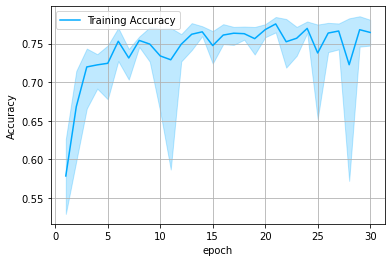

In [20]:
f, ax = plt.subplots()

ax.fill_between(range(1, EPOCHS+1), np.max(history, axis=0), np.min(history,axis=0) , alpha=0.25, color="#00aaff")

ax.plot(range(1, EPOCHS+1), np.average(history, axis=0), color="#00aaff", label="Training Accuracy")
plt.ylabel('Accuracy')
plt.xlabel('epoch')
ax.legend()
ax.grid(True)


In [21]:
# cross validation training accuracy
np.mean(train_acc)

0.7734648

In [22]:
# cross validation testing accuracy
np.mean(test_acc)

0.77266616

In [23]:
X_test = X_test.reset_index().drop(['index'], axis=1)

## Predict individual sample

In [24]:
index = 3 # or any other number

In [25]:
test_sample = X_test.loc[index]
test_sample = np.array(test_sample).reshape(1, -1)

In [26]:
test_sample

array([[71. ,  1. , 24. , 86. , 36.2,  0. ,  1. ,  1. ,  0. ]])

In [27]:
model.predict(test_sample)

array([[0.9951723]], dtype=float32)

In [28]:
y_test.reset_index().drop(['index'], axis=1).loc[index]

STROKE    1
Name: 3, dtype: int64

In [29]:
#model.save_weights('sesuatu')

In [30]:
from firebase import firebase
firebase = firebase.FirebaseApplication('https://stroke-25f59.firebaseio.com', None)

In [31]:
riskfactors = firebase.get('/riskFactors', None)
vitalsigns = firebase.get('/vitalsigns', None)

In [32]:
df = pd.DataFrame(riskfactors.values()).T
df.columns=riskfactors.keys()
df

,age,dm,gender,heartDisease,hypertension,name,smoking
0,24,False,False,False,False,Novhel,False


In [33]:
df['smoking'] = df['smoking'].astype(int)
df['dm'] = df['dm'].astype(int)
df['gender'] = df['gender'].astype(int)
df['heartDisease'] = df['heartDisease'].astype(int)
df['hypertension'] = df['hypertension'].astype(int)
df = df.drop('name', axis=1)

In [34]:
df

,age,dm,gender,heartDisease,hypertension,smoking
0,24,0,0,0,0,0


In [35]:
df2 = pd.DataFrame(vitalsigns.values()).T
df2.columns=vitalsigns.keys()
df2

,heartRate,respiratoryRate,temperature
0,88.0,12.0,36.5


In [36]:
df = pd.concat([df,df2], axis=1)
df = df[['age', 'gender', 'respiratoryRate', 'heartRate', 'temperature', 'hypertension', 'dm', 'heartDisease', 'smoking']]


In [37]:
df

,age,gender,respiratoryRate,heartRate,temperature,hypertension,dm,heartDisease,smoking
0,24,0,12.0,88.0,36.5,0,0,0,0


## Predict from Db

In [38]:
inputX = df.loc[0]
inputX = np.array(inputX, dtype=np.int).reshape(1, -1)

In [39]:
inputX

array([[24,  0, 12, 88, 36,  0,  0,  0,  0]])

In [40]:
model.predict(inputX)

array([[0.08536284]], dtype=float32)

In [ ]:
model.predict(df)

In [ ]:
X.loc[0]

In [ ]:
df.loc[0]